In [1]:
import os
import glob
import copy
import math
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import keras as kr
import tensorflow as tf
from keras.applications import EfficientNetV2B0

from V_Nets import get_algebra, print_algebra
from V_EfficientNetV2 import V_EfficientNetV2B0

2025-05-08 09:38:53.333394: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 09:38:53.340458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746707933.349271 1099291 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746707933.351899 1099291 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-08 09:38:53.360685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Load the dataset

In this experiment, we used the ALL-IDB dataset which can be freely obtained at https://scotti.di.unimi.it/all/

In [3]:
image_size = (128,128)
dataset_path = "/home/valle/DataSets/ALL_IDB/ALL_IDB2/img/*.tif"

imgs_list = [f for f in glob.glob(dataset_path)]
N = len(imgs_list)

Xr_rgb = np.zeros((N,image_size[0],image_size[1],3))
Xq_hsv = np.zeros((N,image_size[0],image_size[1],4))
y = np.zeros((N,))

for i,img_path in enumerate(imgs_list):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, image_size)

    # RGB images
    Xr_rgb[i,:,:,:] = img_resized

    # Convert to HSV
    img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
    H = np.reshape((2*np.pi/180)*img_hsv[:,:,0],(image_size[0],image_size[1],1))
    S = np.reshape(img_hsv[:,:,1]/255,(image_size[0],image_size[1],1))
    V = np.reshape(img_hsv[:,:,2]/255,(image_size[0],image_size[1],1))

    # Quaternion-valued images obtained using HSV;
    Xq_hsv[i,:,:,:] = np.concatenate([np.cos(H)*S,np.cos(H)*V,np.sin(H)*S,np.sin(H)*V],axis=2)

    ind = img_path.find(".tif")
    y[i] = int(img_path[ind-1])

# Partition the dataset

In [5]:
num_classes = 2
y = kr.utils.to_categorical(y, num_classes)

In [6]:
indtr, indte, ytr, yte = train_test_split(range(260), y, test_size=0.5, random_state=17)

# Show some images from the training set:

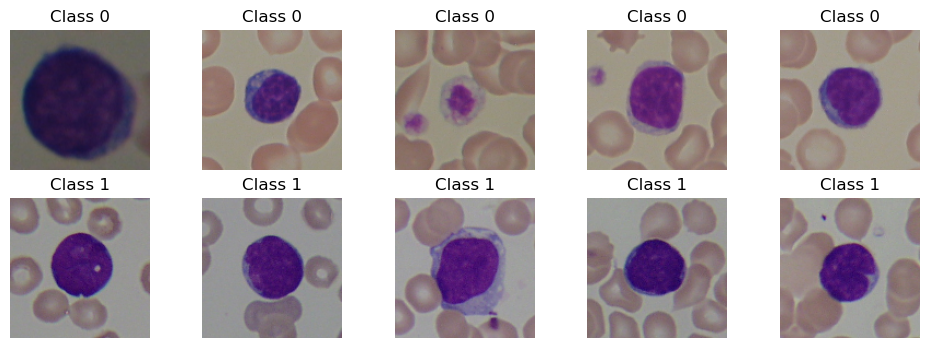

In [8]:
plt.figure(figsize=(12,4))

for i,p in enumerate(np.where(ytr[:,0]>ytr[:,1])[0][:5]):
    plt.subplot(2,5,i+1)
    plt.imshow(Xr_rgb[indtr[p],:,:,:]/255)
    plt.title("Class 0")
    plt.axis(False)

for i,p in enumerate(np.where(ytr[:,0]<ytr[:,1])[0][:5]):
    plt.subplot(2,5,i+6)
    plt.imshow(Xr_rgb[indtr[p],:,:,:]/255)
    plt.title("Class 1")
    plt.axis(False)

# Data Augmentation Layers

In [10]:
img_augmentation_layers = [
    kr.layers.RandomRotation(factor=0.15),
    kr.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    kr.layers.RandomFlip(),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

I0000 00:00:1746707935.636789 1099291 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1098 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [11]:
def learning_rate_schedule(epoch):
    # Warmup phase
    if epoch < 2.4:
        warmup_rate = 0.001 * (epoch / 2.4)
        return warmup_rate
    # Decay phase
    else:
        # Calculate number of decay steps past warmup
        decay_epoch = epoch - 2.4
        # Apply exponential decay with factor 0.97 every 2.4 epochs
        # decay_factor = 0.97 ** (decay_epoch / 2.4)
        decay_factor = 0.96 ** (decay_epoch / 2.4)
        return 0.001 * decay_factor

lr_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)

## Real-valued Dataset

In [13]:
Xtr = Xr_rgb[indtr]
Xte = Xr_rgb[indte]

# Real-Valued EfficientNetV2-B0


In [15]:
inputs = kr.layers.Input(shape=(128, 128, 3))
x = img_augmentation(inputs)
outputs = EfficientNetV2B0(include_top=True, classes=2, input_tensor=inputs, weights=None)(x)
eff_net = kr.Model(inputs, outputs, name="EfficientNetV2B0")

optimizer = optimizer = kr.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.9,
    weight_decay=5.e-5
)
eff_net.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
eff_net.summary()

Model: "EfficientNetV2B0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 128, 128, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 2)              │     5,921,874 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,921,874 (22.59 MB)

 Trainable params: 5,861,266 (22.36 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [16]:
hist_R = eff_net.fit(Xtr,ytr, epochs=400,verbose=0, batch_size=32, validation_data=(Xte,yte), callbacks=[lr_callback])

/home/valle/.local/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
E0000 00:00:1746707950.474669 1099291 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetV2B0_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1746707953.018704 1100601 cuda_dnn.cc:529] Loaded cuDNN version 90501


Text(0.5, 1.0, 'Real-valued EfficientNet B0')

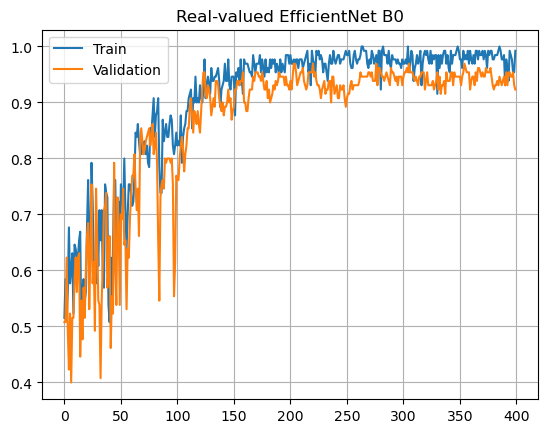

In [17]:
plt.plot(hist_R.history["accuracy"],label="Train")
plt.plot(hist_R.history["val_accuracy"],label="Validation")
plt.legend()
plt.grid(True)
plt.title("Real-valued EfficientNet B0")

# Vector-valued EfficientNetV2 B0

## 4D Dataset (quaternion, hyperbolic quaternion, etc.) with RGB encoding

In [20]:
#RGB-encoded
Xq_rgb = np.concatenate([np.zeros([N, image_size[0],image_size[1],1]),Xr_rgb],axis=3)

Xtr = Xq_rgb[indtr]
Xte = Xq_rgb[indte]

## Quaternion-valued EfficientNet B0

In [22]:
alg = "Quaternions"

inputs = kr.layers.Input(shape=(image_size[0], image_size[1], 4))
x = img_augmentation(inputs)
outputs = V_EfficientNetV2B0(classes=num_classes,
                             input_shape = (image_size[0],image_size[1],4),
                             include_preprocessing = False,
                             algebra = get_algebra(alg),
                             weights=None)(x)
eff_net = kr.Model(inputs, outputs, name="VEfficientNetB0")

optimizer = kr.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.9,
    weight_decay=5.e-5
)

eff_net.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
eff_net.summary()

/home/valle/Dropbox/V-EfficientNet/V_EfficientNetV2.py:379: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "VEfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 4)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 128, 128, 4)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v-efficientnetv2-b0             │ (None, 2)              │     1,782,378 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,782,378 (6.80 MB)

 Trainable params: 1,720,362 (6.56 MB)

 Non-trainable params: 62,016 (242.25 KB)

In [23]:
hist_Q_RGB = eff_net.fit(Xtr,ytr, epochs=400, verbose=0, batch_size=32, validation_data=(Xte,yte), callbacks=[lr_callback])

E0000 00:00:1746708080.819671 1099291 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/VEfficientNetB0_1/v-efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Text(0.5, 1.0, 'Quaternion-valued EfficientNet B0 - RGB Encoding')

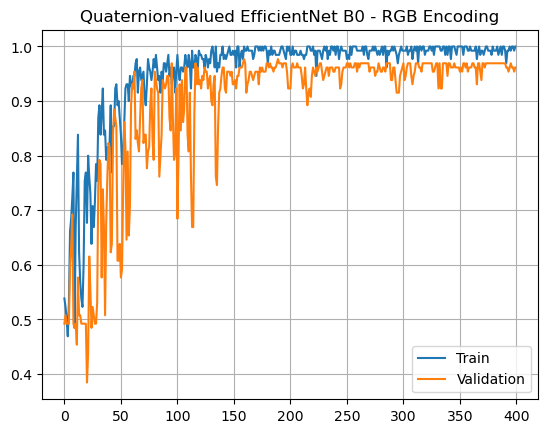

In [24]:
plt.plot(hist_Q_RGB.history["accuracy"],label="Train")
plt.plot(hist_Q_RGB.history["val_accuracy"],label="Validation")
plt.legend()
plt.grid(True)
plt.title("Quaternion-valued EfficientNet B0 - RGB Encoding")

# Using HSV Encoding

In [26]:
# #HSV-encoded
Xtr = Xq_hsv[indtr]
Xte = Xq_hsv[indte]

In [27]:
alg = "Quaternions"

inputs = kr.layers.Input(shape=(image_size[0], image_size[1], 4))
x = img_augmentation(inputs)
outputs = V_EfficientNetV2B0(classes=num_classes,
                             input_shape = (image_size[0],image_size[1],4),
                             include_preprocessing = False,
                             algebra = get_algebra(alg),
                             weights=None)(x)
eff_net = kr.Model(inputs, outputs, name="VEfficientNetB0")

optimizer = kr.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.9,
    weight_decay=5.e-5
)

eff_net.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
eff_net.summary()

Model: "VEfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 4)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 128, 128, 4)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v-efficientnetv2-b0             │ (None, 2)              │     1,782,378 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,782,378 (6.80 MB)

 Trainable params: 1,720,362 (6.56 MB)

 Non-trainable params: 62,016 (242.25 KB)

In [28]:
hist_Q_HSV = eff_net.fit(Xtr,ytr, epochs=400, verbose=0, batch_size=32, validation_data=(Xte,yte), callbacks=[lr_callback])

E0000 00:00:1746708290.932694 1099291 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/VEfficientNetB0_1/v-efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Text(0.5, 1.0, 'Quaternion-valued EfficientNet B0 - HSV Encoding')

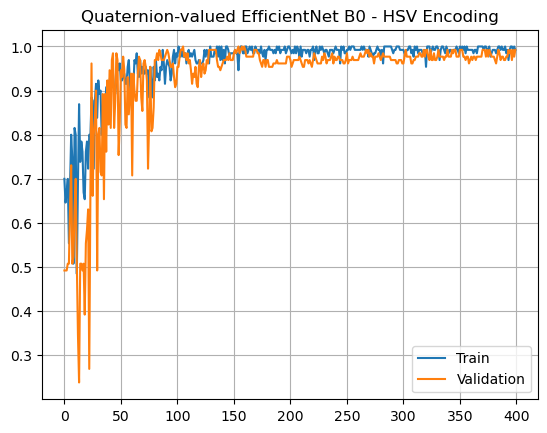

In [29]:
plt.plot(hist_Q_HSV.history["accuracy"],label="Train")
plt.plot(hist_Q_HSV.history["val_accuracy"],label="Validation")
plt.legend()
plt.grid(True)
plt.title("Quaternion-valued EfficientNet B0 - HSV Encoding")

## Hyperbolic-Quaternion-Valued EfficientNet B0 with HSV Encoding

In [31]:
alg = "HyperbolicQuaternions"

inputs = kr.layers.Input(shape=(image_size[0], image_size[1], 4))
x = img_augmentation(inputs)
outputs = V_EfficientNetV2B0(classes=num_classes,
                             input_shape = (image_size[0],image_size[1],4),
                             include_preprocessing = False,
                             algebra = get_algebra(alg),
                             weights=None)(x)
eff_net = kr.Model(inputs, outputs, name="VEfficientNetB0")

optimizer = kr.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.9,
    weight_decay=5.e-5
)

eff_net.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
eff_net.summary()

Model: "VEfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 4)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 128, 128, 4)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v-efficientnetv2-b0             │ (None, 2)              │     1,782,378 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,782,378 (6.80 MB)

 Trainable params: 1,720,362 (6.56 MB)

 Non-trainable params: 62,016 (242.25 KB)

In [32]:
hist_HQ = eff_net.fit(Xtr,ytr, epochs=400, verbose=0, batch_size=32, validation_data=(Xte,yte), callbacks=[lr_callback])

E0000 00:00:1746708498.211956 1099291 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/VEfficientNetB0_1/v-efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Text(0.5, 1.0, 'Quaternion-valued EfficientNet B0 - HSV Encoding')

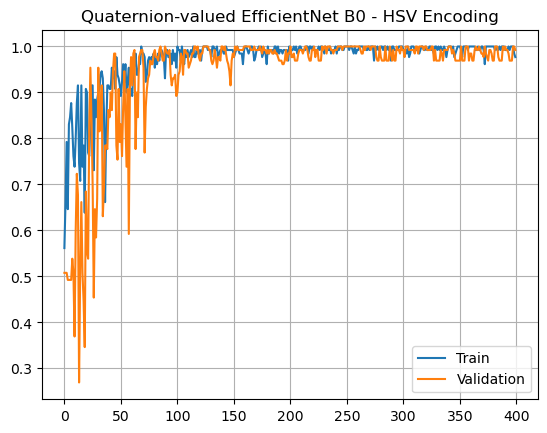

In [33]:
plt.plot(hist_HQ.history["accuracy"],label="Train")
plt.plot(hist_HQ.history["val_accuracy"],label="Validation")
plt.legend()
plt.grid(True)
plt.title("Quaternion-valued EfficientNet B0 - HSV Encoding")

# Comparing the performance of the EfficientNets on the validation set

In [35]:
print("Accuracy:")
print(" Real-valued model: ",hist_R.history["val_accuracy"][-1])
print(" Quaternion-valued model: ",hist_Q_RGB.history["val_accuracy"][-1])
print(" Quaternion-valued model: ",hist_Q_HSV.history["val_accuracy"][-1])
print(" Hyperbolic Quaternion model: ",hist_HQ.history["val_accuracy"][-1])

Accuracy:
 Real-valued model:  0.9230769276618958
 Quaternion-valued model:  0.9615384340286255
 Quaternion-valued model:  0.9923076629638672
 Hyperbolic Quaternion model:  0.9923076629638672
